In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from scipy import stats

In [2]:

class ConditionalPlanarFlow(eqx.Module):
    w: jnp.ndarray
    u: jnp.ndarray
    b: jnp.ndarray
    cond_net: eqx.nn.MLP

    def __init__(self, dim, cond_dim, hidden_size, key):
        wkey, ukey, bkey, netkey = jax.random.split(key, 4)
        self.w = jax.random.normal(wkey, (dim,))
        self.u = jax.random.normal(ukey, (dim,))
        self.b = jax.random.normal(bkey, ())
        self.cond_net = eqx.nn.MLP(
            in_size=cond_dim,
            out_size=dim + dim + 1,  # w, u, and b
            width_size=hidden_size,
            depth=2,
            key=netkey
        )

    def get_params(self, cond):
        params = jax.vmap(self.cond_net)(cond)
        w, u, b = jnp.split(params, [self.w.shape[0], 2*self.w.shape[0]], axis=1)
        return w + self.w, u + self.u, b + self.b

    def forward(self, x, cond):
        w, u, b = self.get_params(cond)
        wx = jnp.sum(x * w, axis=1, keepdims=True)
        activation = jax.nn.tanh(wx + b)
        z = x + activation * u
        psi = (1 - activation**2) * w
        log_det = jnp.log(jnp.abs(1 + jnp.sum(psi * u, axis=1, keepdims=True)))
        return z, log_det

    def inverse(self, z, cond):
        w, u, b = self.get_params(cond)
        def single_inverse(zi, wi, ui, bi):
            xi = zi
            for _ in range(20):
                wx = jnp.dot(xi, wi)
                activation = jax.nn.tanh(wx + bi)
                xi = zi - activation * ui
            log_det = -jnp.log(jnp.abs(1 + jnp.dot((1 - activation**2) * wi, ui)))
            return xi, log_det
        return jax.vmap(single_inverse)(z, w, u, b)

class ConditionalNormalizingFlow(eqx.Module):
    layers: list

    def __init__(self, dim, cond_dim, num_layers, hidden_size, key):
        keys = jax.random.split(key, num_layers)
        self.layers = [ConditionalPlanarFlow(dim, cond_dim, hidden_size, k) for k in keys]

    def forward(self, x, cond):
        log_det_sum = jnp.zeros(x.shape[0])
        for layer in self.layers:
            x, log_det = layer.forward(x, cond)
            log_det_sum += log_det.squeeze()
        return x, log_det_sum

    def inverse(self, z, cond):
        log_det_sum = jnp.zeros(z.shape[0])
        for layer in reversed(self.layers):
            z, log_det = layer.inverse(z, cond)
            log_det_sum += log_det.squeeze()
        return z, log_det_sum


In [3]:
def mean_func(x):
    return jnp.log(x)*(2*x)**2 + x

def std_func(x):
    return 2*x - (x**2) + 0.1

def generate_data(key, size):
    x_key, y_key = jax.random.split(key)
    x = jax.random.uniform(x_key, (size, 1))
    y = mean_func(x) + std_func(x) * jax.random.normal(y_key, (size, 1))
    return x, y

@eqx.filter_value_and_grad
def loss_fn(model, x, y):
    z, log_det = model.inverse(y, x)
    log_prob = jax.scipy.stats.norm.logpdf(z).sum(axis=1) + log_det
    return -jnp.mean(log_prob)

@eqx.filter_jit
def make_step(model, opt_state, x, y):
    loss, grads = loss_fn(model, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

def get_random_batch(x_train, y_train, batch_size, key):
    # Generate random permutation of indices
    num_samples = x_train.shape[0]
    permuted_indices = jax.random.permutation(key, num_samples)
    
    # Select the first batch_size indices
    batch_indices = permuted_indices[:batch_size]
    
    # Select the batch
    return x_train[batch_indices], y_train[batch_indices]

In [35]:
key = jax.random.PRNGKey(7)
sample_size = 300
x_train, y_train = generate_data(key, sample_size)

In [38]:
# Initialize model and optimizer
model = ConditionalNormalizingFlow(dim=1, cond_dim=1, num_layers=3, hidden_size=12, key=jax.random.PRNGKey(1))
optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))


# Training loop with mini-batches
batch_size = 128
key = jax.random.PRNGKey(0)
num_batches = len(x_train) // batch_size
for epoch in range(5000):
    epoch_loss = 0.0
    for i in range(num_batches):
        #x_batch = x_train[i*batch_size:(i+1)*batch_size]
        #y_batch = y_train[i*batch_size:(i+1)*batch_size]

        key, subkey = jax.random.split(key)
        x_batch, y_batch = get_random_batch(x_train, y_train, batch_size, subkey)
        
        loss, model, opt_state = make_step(model, opt_state, x_batch, y_batch)
        epoch_loss += loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Average Loss: {epoch_loss / num_batches}")

    if epoch % 1000 == 0:
        batch_size = jnp.minimum(batch_size+30, sample_size)

Epoch 0, Average Loss: 2.4543652534484863
Epoch 10, Average Loss: 1.7685891389846802
Epoch 20, Average Loss: 1.3526766300201416
Epoch 30, Average Loss: 1.2820080518722534
Epoch 40, Average Loss: 1.1974265575408936
Epoch 50, Average Loss: 1.2662394046783447
Epoch 60, Average Loss: 1.262021541595459
Epoch 70, Average Loss: 1.1476805210113525
Epoch 80, Average Loss: 1.2045292854309082
Epoch 90, Average Loss: 1.215247392654419
Epoch 100, Average Loss: 1.2072315216064453
Epoch 110, Average Loss: 1.2099955081939697
Epoch 120, Average Loss: 1.1307010650634766
Epoch 130, Average Loss: 1.1403417587280273
Epoch 140, Average Loss: 1.0963282585144043
Epoch 150, Average Loss: 1.1279699802398682
Epoch 160, Average Loss: 1.1355957984924316
Epoch 170, Average Loss: 1.039381742477417
Epoch 180, Average Loss: 1.0874605178833008
Epoch 190, Average Loss: 1.0859726667404175
Epoch 200, Average Loss: 0.9988796710968018
Epoch 210, Average Loss: 1.2413756847381592
Epoch 220, Average Loss: 1.3218642473220825
Ep

: 

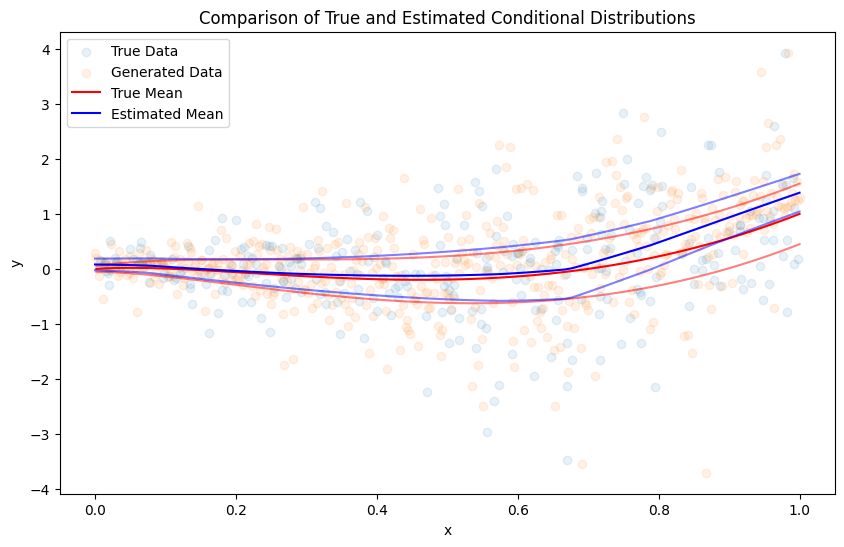

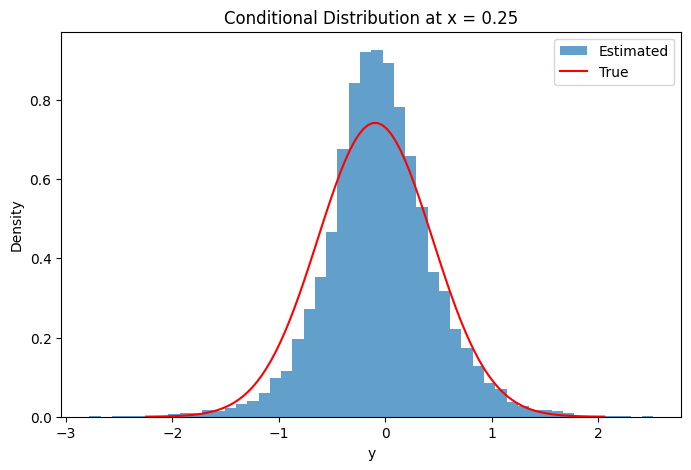

Sample Mean: -0.05849776417016983 | True Mean -0.0965735912322998
Sample Variance: 0.25380939245224 | True Variance 0.28890625


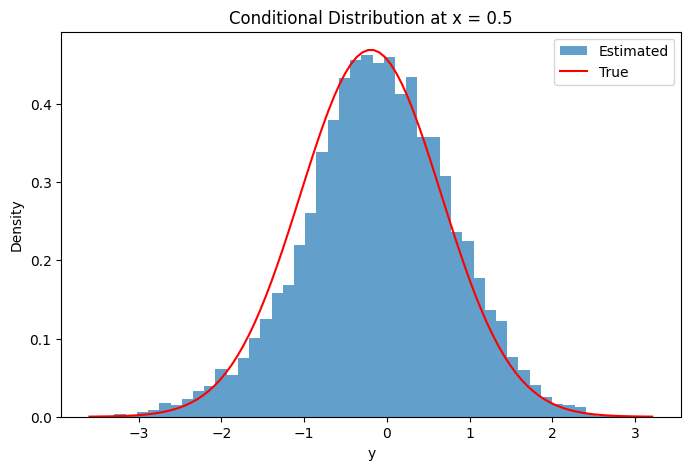

Sample Mean: -0.10740993171930313 | True Mean -0.1931471824645996
Sample Variance: 0.7893460988998413 | True Variance 0.7224999999999999


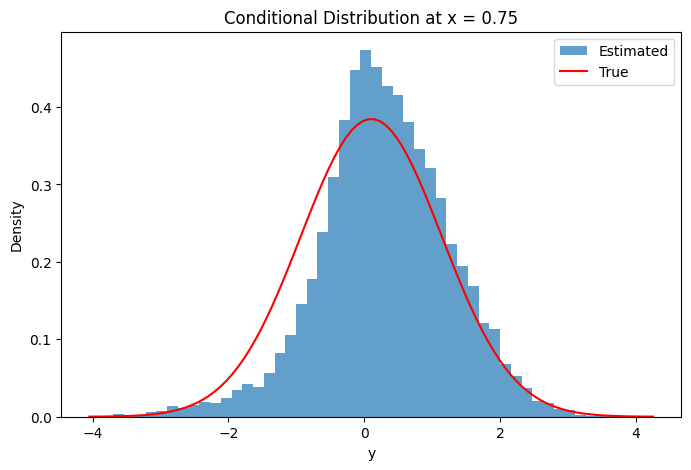

Sample Mean: 0.29668110609054565 | True Mean 0.10271531343460083
Sample Variance: 0.9227420091629028 | True Variance 1.0764062500000002


In [37]:
# Generate samples from the learned distribution
x_test = jnp.linspace(0, 1, 500).reshape(-1, 1)
z = jax.random.normal(jax.random.PRNGKey(2), (500, 1))
estimated_samples, _ = model.forward(z, x_test)

x_means = jnp.linspace(0, 1, 100).reshape(-1, 1)
means = []
stds = []

for x in x_means:
    result = model.forward(z, jnp.array([x]))[0]
    means += result.mean(),
    stds += result.std(),

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, alpha=0.1, label='True Data')
plt.scatter(x_test, estimated_samples, alpha=0.1, label='Generated Data')
plt.plot(x_test, mean_func(x_test), 'r', label='True Mean')
plt.plot(x_test, mean_func(x_test)+0.5*std_func(x_test), 'r', alpha=0.5)
plt.plot(x_test, mean_func(x_test)-0.5*std_func(x_test), 'r', alpha=0.5)
plt.plot(x_means, means, 'b', label='Estimated Mean')
plt.plot(x_means, jnp.array(means)+0.5*jnp.array(stds), 'b', alpha=0.5)
plt.plot(x_means, jnp.array(means)-0.5*jnp.array(stds), 'b', alpha=0.5)
plt.legend()
plt.title('Comparison of True and Estimated Conditional Distributions')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Conditional distribution at specific x values
x_values = [0.25, 0.5, 0.75]
for x_val in x_values:
    x_cond = jnp.full((10000, 1), x_val)
    z = jax.random.normal(jax.random.PRNGKey(3), (10000, 1))
    samples, _ = model.forward(z, x_cond)
    
    plt.figure(figsize=(8, 5))
    plt.hist(samples, bins=50, density=True, alpha=0.7, label='Estimated')
    true_mean = mean_func(x_val)
    true_dist = stats.norm(true_mean, std_func(x_val))
    x_range = jnp.linspace(true_mean - 4*std_func(x_val), true_mean + 4*std_func(x_val), 100)
    plt.plot(x_range, true_dist.pdf(x_range), 'r', label='True')
    plt.title(f'Conditional Distribution at x = {x_val}')
    plt.xlabel('y')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    print(f'Sample Mean: {samples.mean()} | True Mean {true_mean}')
    print(f'Sample Variance: {samples.var()} | True Variance {std_func(x_val)**2}')